<a href="https://colab.research.google.com/github/thiagofuruchima/ds101/blob/main/inferential_statistics_traditional_x_bootstraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Inferential Statistics - Traditional x Bootstraping

I'm using this notebok to better understand inferential statistics, specially the differences between traditional and bootstraping approaches for confidence interval (CI) estimation and hypothesis testing.

A simple well-know dataset is used in this analysis. This dataset will be taken as our population, and a single Simple Random Sample (SRS) is going to be used.

### Data preparation

We're not going to do a full EDA, since our goal is just to get a better undertanding on inferential statistcs.

In [ ]:
# load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# load the famous titanic dataset
df = sns.load_dataset('titanic')

In [ ]:
# check the shape
df.shape

(891, 15)

In [ ]:
# check the datatypes
df.dtypes

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object

In [ ]:
# check for null values
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [ ]:
# check the first 5 rows
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [ ]:
# Take a SRS from the population
sample_size = 100
sample_df = df.sample(sample_size, replace=True)

### What is the 95% CI for the 'fare' price

In [ ]:
# Compute the mean, std for the 'fare' from our population
# This is not going to be used in inference, it is just for comparision
pop_mean, pop_std = df['fare'].mean(), df['fare'].std()
pop_mean, pop_std

(32.2042079685746, 49.693428597180905)

#### Traditional


In [ ]:
# calculate the sample_mean and sample_standard_deviation
sample_mean = sample_df['fare'].mean()
standard_error = sample_df['fare'].std()/np.sqrt(sample_size)

sample_mean, standard_error

(32.98654100000002, 4.365584182314775)

In [ ]:
# the critical value for 95% CI using the Z-Dist
stats.norm.ppf(0.025), stats.norm.ppf(.975)

(-1.9599639845400545, 1.959963984540054)

In [ ]:
# the critical value for 95% CI using the T-Dist
stats.t.ppf(0.025, df=sample_size-1), stats.t.ppf(.975, df=sample_size-1)

(-1.9842169515086832, 1.9842169515086827)

Since we're inferencing the population mean, and our sample size is 'small', we can't use the z-distribution, and have to use the t-distribution

In [ ]:
# Calculate the critical value for 95% CI (between 2.5% and 97.5%)
critical_value = stats.t.ppf(.975, df=sample_size-1)

critical_value

1.9842169515086827

In [ ]:
# Calculate the 95% CI
ci_lower = sample_mean-standard_error*critical_value
ci_upper = sample_mean+standard_error*critical_value

ci_lower, ci_lower

(24.324274862212867, 24.324274862212867)

In [ ]:
# Print the results
print("Statistic:", sample_mean)
print("Confidence Interval:", ci_lower, ci_upper)
print("Margin of Error: +-", critical_value*standard_error)

Statistic: 32.98654100000002
Confidence Interval: 24.324274862212867 41.648807137787166
Margin of Error: +- 8.662266137787148


In [ ]:
# 95% CI using the statsmodels
sms.DescrStatsW(sample_df['fare']).tconfint_mean(alpha=0.05)

(24.32427486221286, 41.64880713778716)

In [ ]:
# 95% CI using the scipy
stats.t.interval(0.95, df=sample_size-1 ,loc=sample_mean, scale=standard_error)

(24.324274862212867, 41.648807137787166)

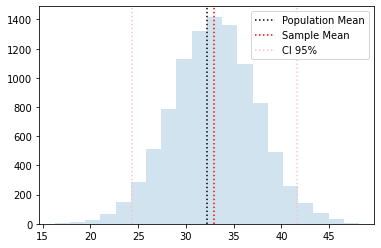

In [ ]:
# Plot the sample distribution 
plt.hist(np.random.normal(sample_mean, standard_error, 10000), bins=20, alpha=.2)
plt.axvline(x = pop_mean, color = "black", linestyle = "dotted", label='Population Mean')
plt.axvline(x = sample_mean, color = "red", linestyle = "dotted", label='Sample Mean')
plt.axvline(x = ci_lower, color = "pink", linestyle = "dotted", label='CI 95%')
plt.axvline(x = ci_upper, color = "pink", linestyle = "dotted")
plt.legend()
plt.show()

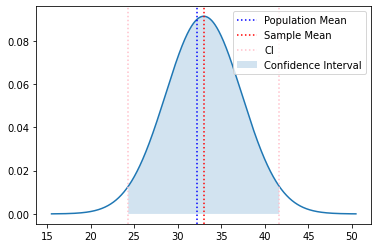

In [ ]:
# Plot the sample distribution 
x = np.linspace(sample_mean - 4 * standard_error, sample_mean + 4 * standard_error, 10000)
y = stats.norm.pdf(x, sample_mean, standard_error)
z = x[(x >= ci_lower) & (x <= ci_upper)]
plt.plot(x, y)
plt.fill_between(z, 0, stats.norm.pdf(z, sample_mean, standard_error), alpha=.2, label="Confidence Interval")
plt.axvline(x = pop_mean, color = "blue", linestyle = "dotted", label='Population Mean')
plt.axvline(x = sample_mean, color = "red", linestyle = "dotted", label='Sample Mean')
plt.axvline(x = ci_lower, color = "pink", linestyle = "dotted", label='CI')
plt.axvline(x = ci_upper, color = "pink", linestyle = "dotted")
plt.legend()
plt.show()

#### Bootstraping
1. Take the sample
2. Take n bootstrap samples from the sample
3. Compute the mean for each bootstrap sample
4. Compute the percentiles (.025 and .0975) of the bootstrap sample means

In [ ]:
# take n bootstrap samples from the sample
bootstrap_means_list = []
for _ in range(10000):
  # take one bootstrap sample
  bootstrap_sample = sample_df.sample(sample_size, replace=True)
  # compute the statistic for each sample
  bootstrap_mean = bootstrap_sample['fare'].mean()
  # add to the list
  bootstrap_means_list.append(bootstrap_mean)

# use the list to generate a DataFrame (for ease of use)
bootstrap_means_df = pd.DataFrame({"Bootstrap":bootstrap_means_list})

In [ ]:
# Calculate the sample distribution mean
bootstrap_mean = bootstrap_means_df['Bootstrap'].mean()
bootstrap_mean

32.92211560120008

In [ ]:
# Calculate the 95% CI using the percentiles from the bootstrap sample means
bootstrap_ci_lower = bootstrap_means_df['Bootstrap'].quantile(.025)
bootstrap_ci_upper = bootstrap_means_df['Bootstrap'].quantile(.975)
bootstrap_ci_lower, bootstrap_ci_upper

(25.119857099999994, 42.182601274999996)

In [ ]:
# Print the results
print("Statistic:", bootstrap_mean)
print("Confidence Interval:", bootstrap_ci_lower, bootstrap_ci_upper)
print("Margin of Error: TODO") # What is the right way to calculate the Margin of Error (since quantiles are not symetric)

Statistic: 32.92211560120008
Confidence Interval: 25.119857099999994 42.182601274999996
Margin of Error: TODO


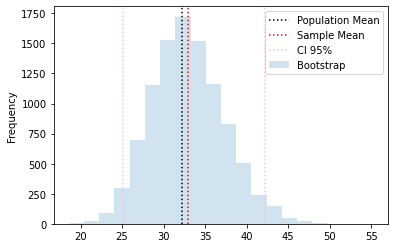

In [ ]:
# plot the distribution from the bootstrap means 
bootstrap_means_df.plot(kind='hist', bins=20, alpha=0.2)
plt.axvline(x = pop_mean, color = "black", linestyle = "dotted", label='Population Mean')
plt.axvline(x = bootstrap_mean, color = "red", linestyle = "dotted", label='Sample Mean')
plt.axvline(x = bootstrap_ci_lower, color = "pink", linestyle = "dotted", label='CI 95%')
plt.axvline(x = bootstrap_ci_upper, color = "pink", linestyle = "dotted")
plt.legend()
plt.show()

### Do men pay more for the ticket than women?

$$H_0: \mu_{male} - \mu_{female} \le 0$$

$$H_1: \mu_{male} - \mu_{female} \gt 0$$

#### Traditional

The traditional approach to this type of hypothesis is to perform a t-test for the means of two independent samples, a.k.a. Two Sample T-Test.

In [ ]:
# define the significance level for our hypotesis tests
alpha = 0.05

In [ ]:
# separate the gender's fare's in two dataframes
male_fares_df = sample_df[sample_df['sex']=='male']['fare']
female_fares_df = sample_df[sample_df['sex']=='female']['fare']

In [ ]:
# Performe the levene test to check if the variances are statistically equal or not,
_, pvalue_levene = stats.levene(male_fares_df, female_fares_df)

# use levene's result to decide if the variances are equal or not 
equal_variances = pvalue_levene < alpha

equal_variances

True

In [ ]:
# Use scypy.stats.ttest_ind to perform the two sample t-test
_, pvalue_ttest = stats.ttest_ind(male_fares_df, female_fares_df, equal_var=equal_variances)

pvalue_ttest

0.006436598101480664

In [ ]:
# Use the t-test two sample result to evaluate H0
if (pvalue_ttest < alpha):
  print("We have evidence to reject the null hypothesis. Men pay more for tickets than women.")
else:
  print("We don't have evidence to reject the null hypothesis. Men don't pay more for tickets than women.")

We have evidence to reject the null hypothesis. Men pay more for tickets than women.


#### Bootstrap

In [ ]:
bootstrap_means_male, bootstrap_means_female = [], []

for _ in range(10000):
  bootstrap_sample = sample_df.sample(sample_size, replace=True)
  bootstrap_means_male.append(bootstrap_sample[bootstrap_sample['sex']=='male']['fare'].mean())
  bootstrap_means_female.append(bootstrap_sample[bootstrap_sample['sex']=='female']['fare'].mean())

bootstrap_means_df = pd.DataFrame({'male':bootstrap_means_male, 'female':bootstrap_means_female})
bootstrap_means_df['diff'] = bootstrap_means_df['male']-bootstrap_means_df['female']

In [ ]:
bootstrap_means_df.head()

,male,female,diff
0,20.701825,37.970370,-17.268546
1,20.026897,37.616928,-17.590031
2,19.589256,46.675125,-27.085869
3,24.985448,49.197380,-24.211932
4,32.526038,53.879691,-21.353652


In [ ]:
print(bootstrap_means_df['male'].mean())
print(bootstrap_means_df['female'].mean())

24.94628141666296
50.20057610285842


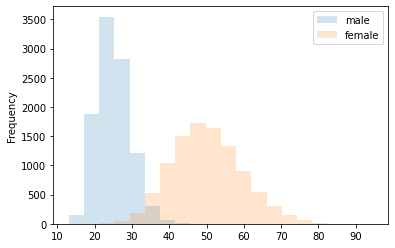

In [ ]:
bootstrap_means_df[['male', 'female']].plot(kind='hist', bins=20, alpha=.2)

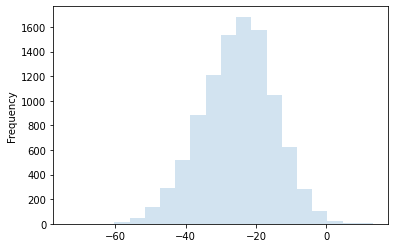

In [ ]:
bootstrap_means_df['diff'].plot(kind='hist', bins=20, alpha=.2)

In [ ]:
# Simulate distribution under the null hypothesis
diff_means_h0 = []
for _ in range(10000):
  diff_means_h0.append(np.random.normal(0, bootstrap_means_df['diff'].std(), size=sample_size).mean())

bootstrap_means_df['diff_h0'] = diff_means_h0

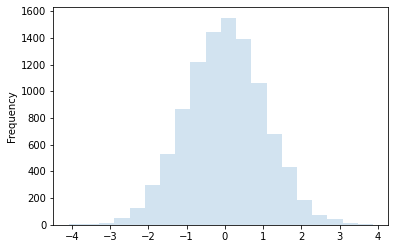

In [ ]:
bootstrap_means_df['diff_h0'].plot(kind='hist', bins=20, alpha=.2)

In [ ]:
# Calculate p_value
pvalue_bootstrap = (bootstrap_means_df['diff']>bootstrap_means_df['diff_h0']).mean()
pvalue_bootstrap

0.004

In [ ]:
# Use the bootstrap's pvalue to evaluate H0
if (pvalue_bootstrap < alpha):
  print("We have evidence to reject the null hypothesis. Men pay more for tickets than women.")
else:
  print("We don't have evidence to reject the null hypothesis. Men pay as much as women for tickets.")

We have evidence to reject the null hypothesis. Men pay more for tickets than women.
